In [1]:
from langchain_community.graphs import Neo4jGraph
from dotenv import load_dotenv
import os

load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USER, password=NEO4J_PASSWORD)


/var/folders/_l/c6v61_8n51j1d1jwmssq4ndw0000gn/T/ipykernel_42785/1928442264.py:10: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USER, password=NEO4J_PASSWORD)


In [2]:
# Drop old projection if it exists, then project fresh
graph.query("""
CALL gds.graph.exists('mof_shared_features') YIELD exists
WITH exists
CALL {
  WITH exists
  CALL apoc.do.when(
    exists,
    'CALL gds.graph.drop("mof_shared_features") YIELD graphName RETURN graphName',
    'RETURN "no-drop" AS graphName',
    {}
  ) YIELD value
  RETURN value.graphName AS dropped
}
RETURN dropped
""")

graph.query("""
CALL gds.graph.project(
  'mof_shared_features',
  ['MOF','Application','Property','Linker','Precursor','Solvent'],
  {
    IS_RECOMMENDED_FOR: { type: 'IS_RECOMMENDED_FOR', orientation: 'UNDIRECTED' },
    HAS_PROPERTY:       { type: 'HAS_PROPERTY',       orientation: 'UNDIRECTED' },
    USES:               { type: 'USES',               orientation: 'UNDIRECTED' }
  }
)

""")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (exists) { ... }} {position: line: 4, column: 1, offset: 71} for query: '\nCALL gds.graph.exists(\'mof_shared_features\') YIELD exists\nWITH exists\nCALL {\n  WITH exists\n  CALL apoc.do.when(\n    exists,\n    \'CALL gds.graph.drop("mof_shared_features") YIELD graphName RETURN graphName\',\n    \'RETURN "no-drop" AS graphName\',\n    {}\n  ) YIELD value\n  RETURN value.graphName AS dropped\n}\nRETURN dropped\n'


[{'nodeProjection': {'Application': {'label': 'Application', 'properties': {}},
   'Property': {'label': 'Property', 'properties': {}},
   'Precursor': {'label': 'Precursor', 'properties': {}},
   'Solvent': {'label': 'Solvent', 'properties': {}},
   'MOF': {'label': 'MOF', 'properties': {}},
   'Linker': {'label': 'Linker', 'properties': {}}},
  'relationshipProjection': {'IS_RECOMMENDED_FOR': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'IS_RECOMMENDED_FOR'},
   'HAS_PROPERTY': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'HAS_PROPERTY'},
   'USES': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'USES'}},
  'graphName': 'mof_shared_features',
  'nodeCount': 70763,
  'relationshipCount': 141504,
  'projectMillis': 108}]

In [3]:
# ==== 2) Community detection (flat / level-0) ====
graph.query("""
CALL gds.leiden.write(
  'mof_shared_features',
  {
    writeProperty: 'communityId',
    includeIntermediateCommunities: true
  }
)
YIELD communityCount, modularity

""")

[{'communityCount': 20467, 'modularity': 0.7459904252969936}]

In [4]:
# ==== 3) Materialize :Community nodes and connect MOFs ====
# - Create one Community per communityId
# - Link each MOF with [:IN_COMMUNITY]
graph.query("""
MATCH (m:MOF)
WHERE m.communityId IS NOT NULL
UNWIND range(0, size(m.communityId)-1) AS level
WITH m, level, m.communityId[level] AS cid
MERGE (c:Community {id: toString(cid), level: level})
MERGE (m)-[:IN_COMMUNITY {level: level}]->(c)
""")

[]

In [11]:
'''# (Optional) prune tiny communities (keep only >= 2 MOFs)
graph.query("""
MATCH (c:Community)
OPTIONAL MATCH (c)<-[:IN_COMMUNITY]-(m:MOF)
WITH c, count(m) AS mcount
WHERE mcount < 2
DETACH DELETE c
""")'''

'# (Optional) prune tiny communities (keep only >= 2 MOFs)\ngraph.query("""\nMATCH (c:Community)\nOPTIONAL MATCH (c)<-[:IN_COMMUNITY]-(m:MOF)\nWITH c, count(m) AS mcount\nWHERE mcount < 2\nDETACH DELETE c\n""")'

In [5]:
community_info = graph.query("""
MATCH (c:Community {level: 2})<-[:IN_COMMUNITY]-(m:MOF)   // leaf-level (adjust level as needed)
OPTIONAL MATCH (m)-[:IS_RECOMMENDED_FOR]->(a:Application)
WITH c, m, collect(DISTINCT a.name) AS apps
OPTIONAL MATCH (m)-[:HAS_PROPERTY]->(p:Property)
WITH c, m, apps, collect(DISTINCT p.name + ': ' + p.value + ' ' + coalesce(p.units,'')) AS props
OPTIONAL MATCH (t:Text)-[:MENTIONS|SUPPORTS|SYNTHESIZED_IN]->(m)
OPTIONAL MATCH (t)-[:HAS_SOURCE]->(src:Paper)
WITH c,
     collect(DISTINCT m.refcode) AS mofs,
     [x IN apps WHERE x IS NOT NULL] AS applications,
     [y IN props WHERE y IS NOT NULL] AS properties,
     [e IN collect(DISTINCT {type: t.type, text: t.text, doi: src.doi})
        WHERE e.text IS NOT NULL AND e.text <> '' AND e.text <> '<no justification>'] AS evidence
RETURN c.id AS communityId, c.level AS level, mofs, applications, properties, evidence
ORDER BY communityId
""")


In [16]:
levels = graph.query("""
MATCH (c:Community)
WITH size(c.id) AS levelDepth, count(*) AS communityCount
RETURN levelDepth, communityCount
ORDER BY levelDepth

""")
levels


[{'levelDepth': 1, 'communityCount': 7},
 {'levelDepth': 2, 'communityCount': 53},
 {'levelDepth': 3, 'communityCount': 985},
 {'levelDepth': 4, 'communityCount': 4122},
 {'levelDepth': 5, 'communityCount': 19566}]

In [6]:
print(f"Communities fetched: {len(community_info)}")
print("Sample:", community_info[-1])


Communities fetched: 14699
Sample: {'communityId': '999', 'level': 2, 'mofs': ['MAVLIH'], 'applications': [], 'properties': ['Coordination Geometry: Distorted octahedral {CdN2O4} or {CdO6} ', 'Topology: Trinodal 3,4,5-connected net with the 3,4,5L45 topology '], 'evidence': [{'text': 'The 2D coordination polymers 8–10 were also generated under similar hydrothermal conditions but using different cadmiumIJII) salts as a starting material (Scheme 3).', 'type': 'Synthesis Justification', 'doi': '10.1039/C7CE00219J'}, {'text': '"Both Cd1 and Cd2 centers are six-coordinate and possess a distorted octahedral {CdN2O4} or {CdO6} environment, respectively."', 'type': 'Property Justification', 'doi': '10.1039/C7CE00219J'}, {'text': '"Topologically, this 2D layer is similar to 5, representing a trinodal 3,4,5-connected net with the 3,4,5L45 topology."', 'type': 'Property Justification', 'doi': '10.1039/C7CE00219J'}]}


In [21]:
community_info[1400]

{'communityId': '12323',
 'mofs': ['LUMLIQ'],
 'applications': [],
 'properties': ['Synthesis Yield: 74 %',
  'Pore Volume: 9.3 %',
  'Topology: 4,4,5T14 '],
 'evidence': [{'text': 'This complex was obtained in a similar method to that of 1, but Zn(NO3)2·6H2O was replaced by Cd(NO3)2·4H2O (0.49g; 1.6mmol). Colorless crystals of 5 were obtained (yield: 0.298g, 74% based on Cd(NO3)2·4H2O).',
   'type': 'Synthesis Justification',
   'doi': '10.1016/j.ica.2015.05.003'},
  {'text': 'The void space was calculated using PLATON, suggesting 9.3% (168.0Å3) void volume to the total crystal volume.',
   'type': 'Property Justification',
   'doi': '10.1016/j.ica.2015.05.003'},
  {'text': 'Complex 5 consists of three dimensional (3D) (4,4,5)-connected net with 4,4,5T14 topology (Fig. 10b).',
   'type': 'Property Justification',
   'doi': '10.1016/j.ica.2015.05.003'},
  {'text': 'Colorless crystals of 5 were obtained (yield: 0.298g, 74% based on Cd(NO3)2·4H2O).',
   'type': 'Property Justification',


In [28]:
from tqdm import tqdm
from openai import OpenAI

client = OpenAI()

# Get only levelDepth 5 communities
level5_comms = graph.query("""
MATCH (c:Community)<-[:IN_COMMUNITY]-(m:MOF)
WHERE size(c.id) = 2
OPTIONAL MATCH (m)-[:IS_RECOMMENDED_FOR]->(a:Application)
WITH c, m, collect(DISTINCT a.name) AS apps
OPTIONAL MATCH (m)-[:HAS_PROPERTY]->(p:Property)
WITH c, m, apps, collect(DISTINCT p.name + ': ' + p.value + ' ' + coalesce(p.units,'')) AS props
OPTIONAL MATCH (t:Text)-[:MENTIONS|SUPPORTS|SYNTHESIZED_IN]->(m)
OPTIONAL MATCH (t)-[:HAS_SOURCE]->(src:Paper)
WITH c,
     collect(DISTINCT m.refcode) AS mofs,
     [x IN apps WHERE x IS NOT NULL] AS applications,
     [y IN props WHERE y IS NOT NULL] AS properties,
     [e IN collect(DISTINCT {type: t.type, text: t.text, doi: src.doi})
        WHERE e.text IS NOT NULL AND e.text <> '' AND e.text <> '<no justification>'] AS evidence
RETURN c.id AS communityId, mofs, applications, properties, evidence
ORDER BY communityId
LIMIT 5
""")

# Summarize 5 communities
summaries = []
for comm in tqdm(level5_comms, desc="Summarizing level 5 communities"):
    content = f"""
Community ID: {comm['communityId']}

MOFs:
{', '.join(comm.get('mofs', []))}

Applications:
{', '.join([a for a in comm.get('applications', []) if a])}

Properties:
{', '.join([p for p in comm.get('properties', []) if p])}

Evidence (sampled justifications):
{" | ".join([e['text'] for e in comm.get('evidence', [])[:5]])}
"""

    response = client.chat.completions.create(
        model="gpt-5-nano",  # or gpt-5-nano for cheaper/faster runs
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an expert Metal-Organic Framework (MOF) Chemist "
                    "A subset of MOFs has been flagged as similar based on shared applications, properties, and more."
                    "It is your job to reason as to why these MOFs are grouped together. "
                    "Provide a brief summary of the community, focusing on share similarities and key features. "
                    "Be concise but emphasize the most distinct, non-trivial insights. "
                    "Keep your response under 150 words. Be sure to include the MOF names at the start of your summary."
                )
            },
            {
                "role": "user",
                "content": f"Summarize the following MOF community:\n{content}"
            }
        ],
        #temperature=0.4
    )

    summaries.append({
        "communityId": comm["communityId"],
        "summary": response.choices[0].message.content
    })

summaries


Summarizing level 5 communities: 100%|██████████| 5/5 [00:55<00:00, 11.17s/it]


[{'communityId': '11',
  'summary': 'OPURIB01\n\n- Core reason for grouping: The cluster appears driven by documentation gaps (missing synthesis/properties data) rather than confirmed chemical similarity, mirroring Ce−MDIP1/2’s lack of procedural details.\n\n- Suspected chemical theme: If aligned with the Ce−MDIP family, this group likely revolves around lanthanide-based nodes with MDIP-type linkers, often pursued for redox/catalytic or adsorption applications, though OPURIB01’s specifics are not stated.\n\n- Key, non-trivial insight: The primary signal is a metadata/reproducibility issue in the dataset—not a validated chemical feature—highlighting the need for accessible synthesis and property data to clarify actual similarities among these MOFs.'},
 {'communityId': '12',
  'summary': 'RUGPAM: Zn2(BPPA)2(BDC)2·6H2O (C60H54N6O14Zn2, MW 1213.14). Monoclinic crystal system, P21/c; V = 8383(3) Å3; density 0.876 g cm−3. Forms a 4-fold interpenetrated 3D network with sra topology. Hydration

In [24]:
summaries[3]

{'communityId': '10086',
 'summary': '- Community 10086 focuses on UDADAH01, an Ag(I)-based MOF/coordination polymer formed with the HL3-p ligand, crystallizing as Ag(HL3-p)NO3.\n\n- Key chemical features\n  - Metal center: Silver(I)\n  - Organic linker: HL3-p (multidentate N-donor character implied by the ligand name)\n  - Counterion/ligand: Nitrate (NO3−) incorporated in the formula\n  - Structure: Coordination polymer / MOF-type assembly suggested by the formula Ag(HL3-p)NO3\n\n- Synthesis and basic properties (from evidence)\n  - Solvothermal synthesis in methanol: HL3-p (6.6 mg, 0.03 mmol) with AgNO3 (5.1 mg, 0.03 mmol) in CH3OH (3 mL)\n  - Conditions: 120 °C for 72 h, followed by slow cooling (–5 °C h–1)\n  - Outcome: Colorless crystals obtained\n\n- Why this MOF groups with others in the same community\n  - Common metal-ligand chemistry: Ag(I) centers coordinated by a multidentate N-donor ligand (HL3-p)\n  - Similar counterion chemistry: nitrate present within the framework\n  -

           mofCount
count  24733.000000
mean       4.676465
std       36.046328
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max     1170.000000


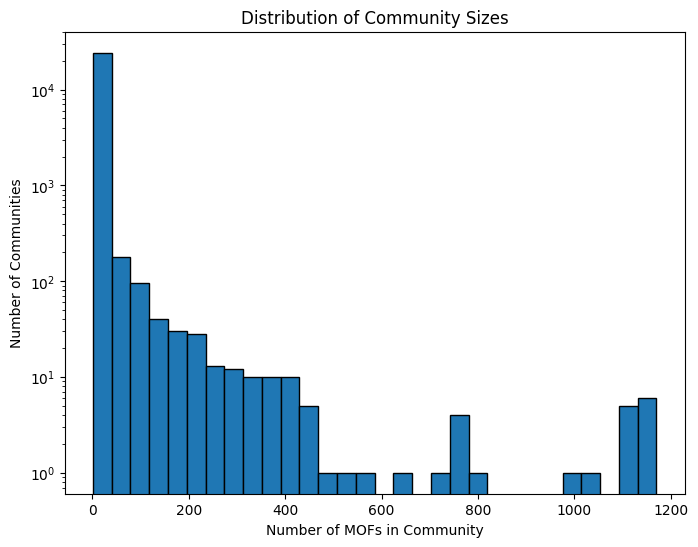

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# query Neo4j for community sizes
results = graph.query("""
MATCH (c:Community)<-[:IN_COMMUNITY]-(m:MOF)
WITH c, count(m) AS mofCount
RETURN c.id AS communityId, mofCount
""")

# convert to DataFrame
df = pd.DataFrame(results)

# quick stats
print(df.describe())

# histogram of community sizes
plt.figure(figsize=(8,6))
plt.hist(df["mofCount"], bins=30, edgecolor="black")
plt.xlabel("Number of MOFs in Community")
plt.ylabel("Number of Communities")
plt.title("Distribution of Community Sizes")
plt.yscale("log")  # often useful if distribution is heavy-tailed

plt.show()



In [32]:
# Query: get community sizes by level
community_sizes = graph.query("""
MATCH (c:Community)<-[:IN_COMMUNITY]-(m:MOF)
WITH c, count(DISTINCT m) AS mofCount, size(c.id) AS levelDepth
RETURN levelDepth, mofCount
""")

import pandas as pd
df = pd.DataFrame(community_sizes)

# Define bins for community sizes
bins = [0, 2, 10, 50, 200, 1000, 1000000]
labels = ["1-2", "3-10", "11-50", "51-200", "201-1000", "1000+"]

df["bin"] = pd.cut(df["mofCount"], bins=bins, labels=labels, right=True)

# Count per level and bin
summary = df.groupby(["levelDepth", "bin"]).size().reset_index(name="numCommunities")

# Pivot for cleaner printing
table = summary.pivot(index="levelDepth", columns="bin", values="numCommunities").fillna(0).astype(int)
print(table)


bin           1-2  3-10  11-50  51-200  201-1000  1000+
levelDepth                                             
1               7     0      0       0         0      0
2              38     5      2       4         3      1
3             885    48     26      14        11      1
4            3406   373    123     155        58      7
5           18135  1003    270     131        23      4


/var/folders/_l/c6v61_8n51j1d1jwmssq4ndw0000gn/T/ipykernel_42785/4290446990.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(["levelDepth", "bin"]).size().reset_index(name="numCommunities")


## So, lets just exclude all communities with 1-5 MOFs and summarize the rest!

In [68]:
all_comms = graph.query("""
MATCH (c:Community)<-[:IN_COMMUNITY]-(m:MOF)
OPTIONAL MATCH (m)-[:IS_RECOMMENDED_FOR]->(a:Application)
WITH c, m, collect(DISTINCT a.name) AS apps
OPTIONAL MATCH (m)-[:HAS_PROPERTY]->(p:Property)
WITH c, m, apps, collect(DISTINCT p.name + ': ' + p.value + ' ' + coalesce(p.units,'')) AS props
OPTIONAL MATCH (t:Text)-[:MENTIONS|SUPPORTS|SYNTHESIZED_IN]->(m)
OPTIONAL MATCH (t)-[:HAS_SOURCE]->(src:Paper)
WITH c,
     collect(DISTINCT m.refcode) AS mofs,
     [x IN apps WHERE x IS NOT NULL] AS applications,
     [y IN props WHERE y IS NOT NULL] AS properties,
     [e IN collect(DISTINCT {type: t.type, text: t.text, doi: src.doi})
        WHERE e.text IS NOT NULL AND e.text <> '' AND e.text <> '<no justification>'] AS evidence
RETURN c.id AS communityId, mofs, applications, properties, evidence
ORDER BY communityId
""")


In [78]:
eligible_comms = [c for c in all_comms if len(c.get("mofs", [])) > 4]

print(f"Total communities: {len(all_comms)}")
print(f"Eligible (>5 MOFs): {len(eligible_comms)}")


Total communities: 112274
Eligible (>5 MOFs): 208


In [79]:
from tqdm import tqdm
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

client = OpenAI()


def summarize_community(comm):
    """Summarize a single community."""
    all_mofs = comm.get("mofs", [])
    sample_mofs = all_mofs[:5]
    mof_text = f"{', '.join(sample_mofs)} ... (total: {len(all_mofs)})"

    apps = [a for a in comm.get("applications", []) if a]
    props = comm.get("properties", [])[:10]
    evidence = [e["text"] for e in comm.get("evidence", []) if e.get("text")]
    evidence = evidence[:5]

    content = f"""
Community ID: {comm['communityId']}

MOFs (sample):
{mof_text}

Applications:
{', '.join(apps)}

Properties (sample):
{', '.join(props)}

Evidence (sampled justifications):
{" | ".join(evidence)}
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # or gpt-5-nano
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are an expert Metal-Organic Framework (MOF) chemist. "
                        "A group of MOFs has been clustered together based on shared features. "
                        "Your task is to analyze why these MOFs might belong in the same research community.\n\n"
                        "Specifically:\n"
                        "- Identify common **applications** (e.g., gas storage, catalysis, drug delivery).\n"
                        "- Identify recurring **properties** (e.g., pore size, surface area, stability values).\n"
                        "- Identify potential **structural similarities** (e.g., same linker type, metal nodes, or topology).\n"
                        "- Provide reasoning about how these factors might be connected.\n\n"
                        "Be concise (≤150 words) and emphasize non-trivial insights. "
                        "Do not just list items — infer why these MOFs are related."
                    )
                },
                {"role": "user", "content": f"Summarize the following MOF community:\n{content}"}
            ],
            temperature=0.4
        )
        summary_text = response.choices[0].message.content
    except Exception as e:
        summary_text = f"Error generating summary: {str(e)}"

    return {
        "communityId": comm["communityId"],
        "mofs": all_mofs,               # keep full list for retrieval
        "applications": apps,
        "properties": props,
        "summary": summary_text
    }

# --- Parallel execution ---
summaries = []
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(summarize_community, comm): comm for comm in eligible_comms}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Summarizing communities"):
        summaries.append(future.result())

# --- Save to JSONL ---
with open("community_summaries.jsonl", "w") as f:
    for rec in summaries:
        f.write(json.dumps(rec) + "\n")

print(f"✅ Saved {len(summaries)} summaries to community_summaries.jsonl")


Summarizing communities: 100%|██████████| 208/208 [03:17<00:00,  1.05it/s]

✅ Saved 208 summaries to community_summaries.jsonl


In [ ]:
from tqdm import tqdm
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

client = OpenAI()


def summarize_community(comm):
    """Summarize a single community."""
    all_mofs = comm.get("mofs", [])
    sample_mofs = all_mofs[:5]
    mof_text = f"{', '.join(sample_mofs)} ... (total: {len(all_mofs)})"

    apps = [a for a in comm.get("applications", []) if a]
    props = comm.get("properties", [])[:10]
    evidence = [e["text"] for e in comm.get("evidence", []) if e.get("text")]
    evidence = evidence[:5]

    content = f"""
Community ID: {comm['communityId']}

MOFs (sample):
{mof_text}

Applications:
{', '.join(apps)}

Properties (sample):
{', '.join(props)}

Evidence (sampled justifications):
{" | ".join(evidence)}
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # or gpt-5-nano
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are an expert Metal-Organic Framework (MOF) chemist. "
                        "A group of MOFs has been clustered together based on shared features. "
                        "Your task is to analyze why these MOFs might belong in the same research community.\n\n"
                        "Specifically:\n"
                        "- Identify common **applications** (e.g., gas storage, catalysis, drug delivery).\n"
                        "- Identify recurring **properties** (e.g., pore size, surface area, stability values).\n"
                        "- Identify potential **structural similarities** (e.g., same linker type, metal nodes, or topology).\n"
                        "- Provide reasoning about how these factors might be connected.\n\n"
                        "Be concise (≤150 words) and emphasize non-trivial insights. "
                        "Do not just list items — infer why these MOFs are related."
                    )
                },
                {"role": "user", "content": f"Summarize the following MOF community:\n{content}"}
            ],
            temperature=0.4
        )
        summary_text = response.choices[0].message.content
    except Exception as e:
        summary_text = f"Error generating summary: {str(e)}"

    return {
        "communityId": comm["communityId"],
        "mofs": all_mofs,               # keep full list for retrieval
        "applications": apps,
        "properties": props,
        "summary": summary_text
    }

# --- Parallel execution ---
summaries = []
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(summarize_community, comm): comm for comm in eligible_comms}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Summarizing communities"):
        summaries.append(future.result())

# --- Save to JSONL ---
with open("community_summaries.jsonl", "w") as f:
    for rec in summaries:
        f.write(json.dumps(rec) + "\n")

print(f"✅ Saved {len(summaries)} summaries to community_summaries.jsonl")


## Now add summaries back onto graph in Community Nodes

In [80]:
for s in summaries:
    graph.query(
        """
        MATCH (c:Community {id: $cid})
        SET c.summary = $summary
        """,
        {"cid": s["communityId"], "summary": s["summary"]}
    )


## We only generated summaries some communities, which means we don't have complete coverage:

In [81]:
covered = graph.query("""
MATCH (c:Community)
WHERE c.summary IS NOT NULL
MATCH (c)<-[:IN_COMMUNITY]-(m:MOF)
RETURN count(DISTINCT m) AS coveredMOFs
""")

total = graph.query("""
MATCH (m:MOF)
RETURN count(m) AS totalMOFs
""")

print("Covered MOFs:", covered[0]["coveredMOFs"])
print("Total MOFs:", total[0]["totalMOFs"])


Covered MOFs: 8344
Total MOFs: 15119


In [87]:
eligible_comms_d = [c for c in all_comms if len(c.get("mofs", [])) > 1]

print(f"Total communities: {len(all_comms)}")
print(f"Eligible (>5 MOFs): {len(eligible_comms_d)}")

Total communities: 112274
Eligible (>5 MOFs): 1437
